### 1.数据预处理

#### 1.1 导入必要库

In [1]:
from sklearn.preprocessing import LabelEncoder
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#### 1.2 数据集获取

In [2]:
# 定义恶意软件家族和文件夹对应关系
families = {
    "Allaple.A": "./Allaple.A",
    "Fakerean": "./Fakerean",
    "Instantaccess": "./Instantaccess",
    "Obfuscator.AD": "./Obfuscator.AD",
    "Skintrim.N": "./Skintrim.N",
    "VB.AT": "./VB.AT",
    "Wintrim.BX": "./Wintrim.BX",
    "Yuner.A": "./Yuner.A"
}

In [3]:
# 自定义Dataset类
class MalwareDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [4]:
# 图像数据和标签列表
X = []
y = []

# 读取图像并转换为张量
for family, folder in families.items():
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # 将图像读取为灰度图并调整为固定大小64x64
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (64, 64))
            X.append(img_resized)
            y.append(family)

In [5]:
X = np.array(X).astype('float32') / 255.0  # 归一化
X = np.expand_dims(X, axis=1)  # 将图像reshape为[N, 1, 64, 64]
y = np.array(y)

In [6]:
# 将标签转换为数值编码
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [8]:
# 创建 Dataset对象和 DataLoader, 使用 DataLoader进行批量处理
train_dataset = MalwareDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = MalwareDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 2.模型构建

In [9]:
# 两个卷积层（conv1, conv2），每层后面跟一个最大池化层（pool）。
# 一个全连接层 fc1，用于从卷积层提取到的特征向量进行分类。
# 最终通过 fc2 输出对应恶意软件家族的分类结果。
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128) 
        self.fc2 = nn.Linear(128, len(families))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)  # 展平
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device

device(type='cuda')

### 3.模型训练

In [11]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [12]:
# 训练模型
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.3420
Epoch [2/10], Loss: 0.0223
Epoch [3/10], Loss: 0.0173
Epoch [4/10], Loss: 0.0062
Epoch [5/10], Loss: 0.0039
Epoch [6/10], Loss: 0.0022
Epoch [7/10], Loss: 0.0021
Epoch [8/10], Loss: 0.0016
Epoch [9/10], Loss: 0.0007
Epoch [10/10], Loss: 0.0003


### 4.模型评估

In [13]:
# 测试函数
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"测试集分类准确率: {accuracy:.3f}%")

    return all_labels, all_preds

In [14]:
# 测试模型
y_test_classes, y_pred_classes = test_model(model, test_loader)

测试集分类准确率: 99.550%


In [15]:
# 混淆矩阵
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("混淆矩阵:")
print(conf_matrix)

混淆矩阵:
[[299   0   0   0   0   0   0   0]
 [  1  14   0   0   0   0   1   0]
 [  0   0  35   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0]
 [  0   0   0   0  12   0   0   0]
 [  0   0   0   0   0  49   0   0]
 [  0   0   0   0   0   0   9   0]
 [  0   0   0   0   0   0   0  13]]


In [16]:
# 归一化混淆矩阵
conf_matrix_normalized = conf_matrix.astype(
    'float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print("归一化的混淆矩阵:")
print(conf_matrix_normalized)

归一化的混淆矩阵:
[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0625 0.875  0.     0.     0.     0.     0.0625 0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]


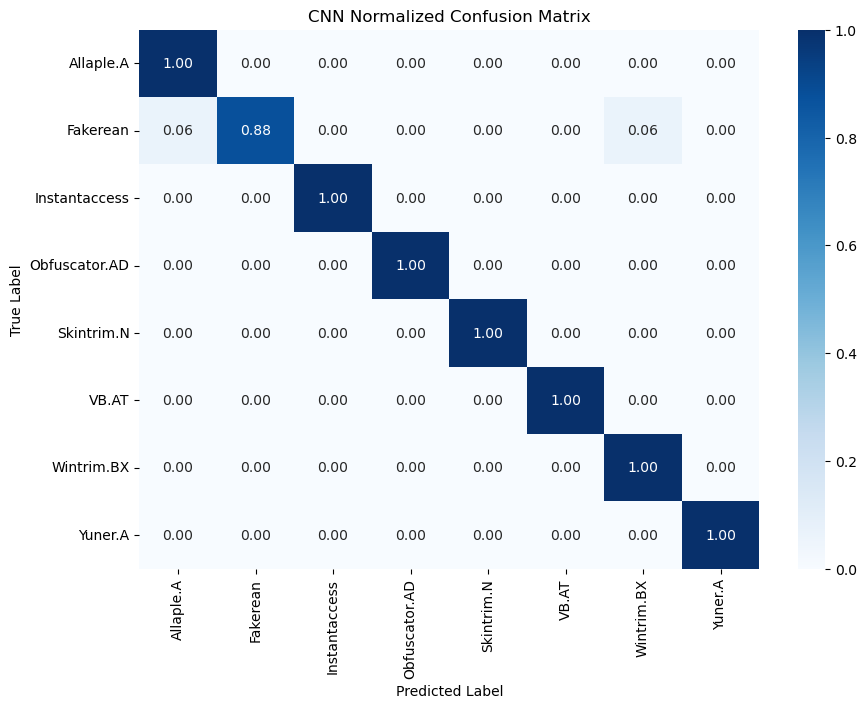

In [17]:
# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f",
            cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("CNN Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()